In [194]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [195]:
# Uploading and preparing training data
training_data = pd.read_excel("Training_Data.xlsx")
training_data.drop("HomeTeam", axis = 1, inplace=True) # Removing unwanted cols
training_data.drop("AwayTeam", axis = 1, inplace=True)

# Getting a list of attributes names
attributes = list(training_data)
attributes.remove('FTR')

# Uploading and preparing testing data similar to training data
testing_data = pd.read_excel("Liverpool.xlsx")
testing_data.drop("HomeTeam", axis = 1, inplace=True)
testing_data.drop("AwayTeam", axis = 1, inplace=True)

# Checking that the data is in the desired format
training_data.head()

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,27,6,10,3,9,12,9,4,0,1,0,0,H
1,6,14,2,4,6,9,3,10,0,2,0,0,A
2,19,10,6,5,16,11,8,5,3,3,2,0,A
3,14,8,4,6,7,19,12,9,1,3,0,0,A
4,9,9,4,1,13,10,6,7,1,1,0,0,H


In [196]:
# Make discretized dataframes:

data_root = training_data.copy()
data_node = training_data.copy()

for attribute in attributes:
    bins = []
    bins.append(np.min(training_data[attribute].values))
    bins.append(np.mean(training_data[attribute].values))
    bins.append(np.max(training_data[attribute].values))
    group_names = ['l', 'h']
    data_root[attribute] = pd.cut(data_root[attribute], bins, labels= group_names, include_lowest=True)
    
for i, attribute in enumerate(attributes):
    bins = []
    rng = training_data[attribute].max() - training_data[attribute].min()
    bins.append(np.min(training_data[attribute].values))
    bins.append(training_data[attribute].min()+ (1/3)*rng)
    bins.append(training_data[attribute].min()+ (2/3)*rng)
    bins.append(np.max(training_data[attribute].values))
    groups = ['l', 'm', 'h']
    data_node[attribute] = pd.cut(training_data[attribute], bins, labels= groups, include_lowest=True)
    
# Checking:
data_node.head(10)

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,h,l,m,l,m,m,m,l,l,l,l,l,H
1,l,m,l,l,l,l,l,h,l,l,l,l,A
2,m,l,m,m,h,m,m,m,m,m,h,l,A
3,m,l,l,m,l,h,m,h,l,m,l,l,A
4,l,l,l,l,m,m,l,m,l,l,l,l,H
5,m,l,m,l,h,l,m,l,m,l,l,l,H
6,m,l,m,l,h,l,m,l,l,l,l,l,H
7,l,m,l,m,l,m,l,m,l,l,m,l,A
8,l,m,l,m,l,m,m,m,l,m,l,l,A
9,m,l,l,l,m,m,l,m,l,l,l,h,A


In [213]:
####################################################################################        
## Function to calculate the entropy of a given data (or subgroup of data)
####################################################################################
def entropy (data):
    
    if((len(data) == 0)or(len(data[data['FTR']=='H']) == 0) or (len(data[data['FTR']=='H']) == len(data))):
        return 0
    p1 = (data[(data['FTR'] == 'H')]).count()[0]/len(data)
    p2 = (data[(data['FTR'] == 'A')]).count()[0]/len(data)
    
    log_p1 = np.log2(p1)
    log_p2 = np.log2(p2)
    
    result = -p1*log_p1 - p2*log_p2
    
    return result

####################################################################################        
## Function to calculate the gain for a given attribute
## data is a DataFrame of the data
## attribute is a string with attribute name
####################################################################################
def gain(data, attribute):
    
    #print(attribute)
    # Initial values to help in debugging
    new_entropy = 1
    result = 0
    
    # Calculate initial entropy:
    previous_entropy = entropy(data)
  #  print('Previous entropy = ', previous_entropy)
    
    # Get new entropies
    data0=data[(data[attribute] == 'l')]
    data1=data[(data[attribute] == 'm')]
    data2=data[(data[attribute] == 'h')]
    new_entropy0 = entropy (data0)
    new_entropy1 = entropy (data1)
    new_entropy2 = entropy (data2)
    
    if (new_entropy0 + new_entropy1 +new_entropy2 ==0):
        return 1
    
    # Get weights for the weighted sum
    if not len(data)==0:
        w0 = len(data0)/ len(data)
        w1 = len(data1)/ len(data)
        w2 = len(data2)/ len(data)
    else:
        result = previous_entropy
        return result
    
    # Weighted sum and difference between previous and new
    new_entropy = w0*new_entropy0 + w1*new_entropy1 + w2*new_entropy2
 #   print ('New entropy = ', new_entropy)
    result = previous_entropy - new_entropy
  #  print ('Result = ', result, '\n\n')
        
    return result


####################################################################################
## Function to get a leaf node value by getting the max repeated value
####################################################################################
def get_leaf_class(data):
    return data.FTR.mode()[0]

####################################################################################
## Function to get the root
####################################################################################
def create_root(data):
    gains = [] # empty list of gains for attributes
    for attribute in attributes:
        data0 = data[(data[attribute] == 'l')]
        data1 = data[(data[attribute] == 'h')]
        w0 = len(data0)/ len(data)
        w1 = len(data1)/ len(data)
        attribute_gain = entropy(data)-w0*entropy(data0)-w1*entropy(data1)
        gains.append(attribute_gain)

    # Save attribute with max gain
    Max_attribute = attributes[np.argmax(gains)]
    root = Max_attribute
    #attributes.remove(Max_attribute)
    
    return root

####################################################################################
## Function to evaluate the best attribute for a node
####################################################################################
def get_node(data):
    gains = [] # empty list of gains for attributes
    leaf_node=0
    for attribute in attributes:
        attribute_gain = gain(data, attribute)
        gains.append(attribute_gain)
    node = attributes[np.argmax(gains)]
    if (np.max(gains)==1):
        leaf_node =1
    
    return node, leaf_node


####################################################################################

def train_tree (data):
    
    # Empty vars to save the trained model.
    global root, node_l, node_h, node_ll, node_lm, node_lh, node_hl, node_hm, node_hh
    global attributes
    root = 'Null'
    node_l = 'Null'
    node_h = 'Null'
    node_ll = 'Null'
    node_lm = 'Null'
    node_lh = 'Null'
    node_hl = 'Null'
    node_hm = 'Null'
    node_hh = 'Null'
    
    global level_4_leafs
    level_4_leafs = []
    for i in range(18):
        level_4_leafs.append('n')
    

    # Getting the root of the tree:
    root = create_root(data_root)
    attributes.remove(root)
    print (root)
  #  print('Root level')
        
    # Left branch:
    data_l = data_node[(data_root[root] == 'l')]
    node_l, leaf = get_node(data_l)
    attributes.remove(node_l)
   # print('1st level')
    
    # Right branch:
    data_h = data_node[(data_root[root] == 'h')]
    node_h, leaf = get_node(data_h)
   # print('1st level')
    
    # Going to next level:
    data_ll = data_l[(data_l[node_l]=='l')]
    node_ll, leaf = get_node(data_ll) ## Which data??!!
    attributes.remove(node_ll)
    ## Three leafs:
    if (leaf):
        level_4_leafs[0]=(get_leaf_class(data_ll)) 
        level_4_leafs[1]=(get_leaf_class(data_ll))
        level_4_leafs[2]=(get_leaf_class(data_ll))    
    else:
        data_lll = data_ll[(data_ll[node_ll]=='l')]
        data_llm = data_ll[(data_ll[node_ll]=='m')]
        data_llh = data_ll[(data_ll[node_ll]=='h')]
        level_4_leafs[0]=(get_leaf_class(data_lll))
        level_4_leafs[1]=(get_leaf_class(data_llm))
        level_4_leafs[2]=(get_leaf_class(data_llh))
  #  print('2nd level 1st branch')
        
    
    data_lm = data_l[(data_l[node_l]=='m')]
    node_lm, leaf = get_node(data_lm) ## Which data??!!
    attributes.remove(node_lm)
    ## Three leafs:
    if (leaf):
        level_4_leafs[3]=(get_leaf_class(data_lm)) 
        level_4_leafs[4]=(get_leaf_class(data_lm))
        level_4_leafs[5]=(get_leaf_class(data_lm))
    else:
        data_lml = data_lm[(data_lm[node_lm]=='l')]
        data_lmm = data_lm[(data_lm[node_lm]=='m')]
        data_lmh = data_lm[(data_lm[node_lm]=='h')]
        level_4_leafs[3]=(get_leaf_class(data_lml)) 
        level_4_leafs[4]=(get_leaf_class(data_lmm))
        level_4_leafs[5]=(get_leaf_class(data_lmh))
   # print('2nd level 2nd branch')
    
    
    data_lh = data_l[(data_l[node_l]=='h')]
    node_lh, leaf = get_node(data_lh) ## Which data??!!
    attributes.remove(node_lh)
    ## Three leafs:
    if (leaf):
        level_4_leafs[6]=(get_leaf_class(data_lh)) 
        level_4_leafs[7]=(get_leaf_class(data_lh))
        level_4_leafs[8]=(get_leaf_class(data_lh))
    
    else:        
        data_lhl = data_lh[(data_lh[node_lh]=='l')]
        data_lhm = data_lh[(data_lh[node_lh]=='m')]
        data_lhh = data_lh[(data_lh[node_lh]=='h')]
        level_4_leafs[6]=(get_leaf_class(data_lhl)) 
        level_4_leafs[7]=(get_leaf_class(data_lhm))
        level_4_leafs[8]=(get_leaf_class(data_lhh))

   # print('2nd level 3rd branch')
    
    # Moving to the other branch:
    attributes.append(node_l)
    attributes.append(node_ll)
    attributes.append(node_lm)
    attributes.append(node_lh)

    data_hl = data_h[(data_h[node_h]=='l')]
    node_hl, leaf = get_node(data_hl) ## Which data??!!
    attributes.remove(node_hl)
    ## Three leafs:
    if (leaf):
        level_4_leafs[9]=(get_leaf_class(data_hl)) 
        #level_4_leafs[10]=(get_leaf_class(data_hl))
        level_4_leafs[10] = 'n'
        level_4_leafs[11] = 'n'
        #level_4_leafs[11]=(get_leaf_class(data_hl))    
    else:
        data_hll = data_hl[(data_hl[node_hl]=='l')]
        data_hlm = data_hl[(data_hl[node_hl]=='m')]
        data_hlh = data_hl[(data_hl[node_hl]=='h')]
        level_4_leafs[9]=(get_leaf_class(data_hll)) 
        #level_4_leafs[10]=(get_leaf_class(data_hlm))
        #level_4_leafs[11]=(get_leaf_class(data_hlh))
        level_4_leafs[10] = 'n'
        level_4_leafs[11] = 'n'
   # print('2nd level 4th branch')
    
    
    data_hm = data_h[(data_h[node_h]=='m')]
    node_hm, leaf = get_node(data_hm) ## Which data??!!
    attributes.remove(node_hm)
    ## Three leafs:
    if (leaf):
        level_4_leafs[12]=(get_leaf_class(data_hm)) 
        level_4_leafs[13]=(get_leaf_class(data_hm))
        level_4_leafs[14]=(get_leaf_class(data_hm))     
    else:
        data_hml = data_hm[(data_hm[node_hm]=='l')]
        data_hmm = data_hm[(data_hm[node_hm]=='m')]
        data_hmh = data_hm[(data_hm[node_hm]=='h')]
        level_4_leafs[12]=(get_leaf_class(data_hml)) 
        level_4_leafs[13]=(get_leaf_class(data_hmm))
        level_4_leafs[14]=(get_leaf_class(data_hmh))
   # print('2nd level 5th branch')
    
    data_hh = data_h[(data_h[node_h]=='h')]
    node_hh, leaf = get_node(data_hh) ## Which data??!!
    ## Three leafs:
    if (leaf):
        level_4_leafs[15]=(get_leaf_class(data_hh)) 
        level_4_leafs[16]=(get_leaf_class(data_hh))
        level_4_leafs[17]=(get_leaf_class(data_hh))
    else:
        data_hhl = data_hh[(data_hh[node_hh]=='l')]
        data_hhm = data_hh[(data_hh[node_hh]=='m')]
        data_hhh = data_hh[(data_hh[node_hh]=='h')]
        level_4_leafs[15]=(get_leaf_class(data_hhl)) 
        level_4_leafs[16]=(get_leaf_class(data_hhm))
        level_4_leafs[17]=(get_leaf_class(data_hhh))
   # print('2nd level 6th branch')
    
    # Just so we can run this cell again without problems
    attributes.append(root)
    attributes.append(node_hl)
    attributes.append(node_hm)
    
    tree = {'root' : root, 'node_l' : node_l, 'node_h': node_h, 'node_ll': node_ll, 'node_lm': node_lm, 'node_lh': node_lh, 'node_hl': node_hl, 'node_hm': node_hm, 'node_hh': node_hh}
    save_tree (tree, level_4_leafs)
        
        

####################################################################################

def save_tree (tree, leafs):
    with open('tree.txt', 'w+') as file:
        for item in tree:
            file.write(item)
            file.write(':    ')
            file.write(tree[item])
            file.write('\n')
        for i, leaf in enumerate(leafs):
            file.write('{} leaf= '.format(i))
            if not (len(leaf) ==0):
                file.write(leaf)
            file.write('\n')



####################################################################################

def test_tree (data):
   
    y_test = data['FTR']
    y_pred = []
    
    for idx, match in data.iterrows():
        #print(idx)
        if (match[root] <= training_data[root].mean()): # Going to left branch
            rng = training_data[node_l].max() - training_data[node_l].min()
            m1 = training_data[node_l].min() + (1/3)*rng
            m2 = training_data[node_l].min() + (2/3)*rng
            
            if match[node_l]<=m1:
                rng2 = training_data[node_ll].max() - training_data[node_ll].min()
                m12 = training_data[node_ll].min() + (1/3)*rng
                m22 = training_data[node_ll].min() + (2/3)*rng
                if match[node_ll]<=m12:   # Reached a leaf node
                    if (level_4_leafs[0]):
                        y_pred.append(level_4_leafs[0])
                    
                elif match[node_ll]<=m22: # Reached a leaf node
                    if not(level_4_leafs[1]=='n'):
                        y_pred.append(level_4_leafs[1])
                    else:
                        y_pred.append(level_4_leafs[0])
                    
                else:                     # Reached a leaf node
                    if not(level_4_leafs[2]=='n'):
                        y_pred.append(level_4_leafs[2])
                    else:
                        y_pred.append(level_4_leafs[0])
                    
            elif match[node_l]<=m2: 
                rng2 = training_data[node_lm].max() - training_data[node_lm].min()
                m12 = training_data[node_lm].min() + (1/3)*rng
                m22 = training_data[node_lm].min() + (2/3)*rng
                if match[node_lm]<=m12:   # Reached a leaf node
                    if (level_4_leafs[3]):
                        y_pred.append(level_4_leafs[3])
                    
                elif match[node_lm]<=m22: # Reached a leaf node
                    if not(level_4_leafs[4]=='n'):
                        y_pred.append(level_4_leafs[4])
                    else:
                        y_pred.append(level_4_leafs[3])
                    
                else:                     # Reached a leaf node
                    if not(level_4_leafs[5]=='n'):
                        y_pred.append(level_4_leafs[5])
                    else:
                        y_pred.append(level_4_leafs[3])
                    
            else:
                rng2 = training_data[node_lh].max() - training_data[node_lh].min()
                m12 = training_data[node_lh].min() + (1/3)*rng
                m22 = training_data[node_lh].min() + (2/3)*rng
                if match[node_lh]<=m12:   # Reached a leaf node
                    if (level_4_leafs[6]):
                        y_pred.append(level_4_leafs[6])
                    
                elif match[node_lh]<=m22: # Reached a leaf node
                    if not(level_4_leafs[7]=='n'):
                        y_pred.append(level_4_leafs[7])
                    else:
                        y_pred.append(level_4_leafs[6])
                    
                else:                     # Reached a leaf node
                    if not(level_4_leafs[8]=='n'):
                        y_pred.append(level_4_leafs[8])
                    else:
                        y_pred.append(level_4_leafs[6])
                    
        
        else: # Going to right branch
            rng = training_data[node_h].max() - training_data[node_h].min()
            m1 = training_data[node_h].min() + (1/3)*rng
            m2 = training_data[node_h].min() + (2/3)*rng
            
            if match[node_h]<=m1:
                rng2 = training_data[node_hl].max() - training_data[node_hl].min()
                m12 = training_data[node_hl].min() + (1/3)*rng
                m22 = training_data[node_hl].min() + (2/3)*rng
                if match[node_hl]<=m12:   # Reached a leaf node
                    if (level_4_leafs[9]):
                        y_pred.append(level_4_leafs[9])
                    
                elif match[node_hl]<=m22: # Reached a leaf node
                    if not(level_4_leafs[10]=='n'):
                        y_pred.append(level_4_leafs[10])
                    else:
                        y_pred.append(level_4_leafs[9])
                    
                else:                     # Reached a leaf node
                    if not(level_4_leafs[11]=='n'):
                        y_pred.append(level_4_leafs[11])
                    else:
                        y_pred.append(level_4_leafs[9])
        
            elif match[node_h]<=m2: 
                rng2 = training_data[node_hm].max() - training_data[node_hm].min()
                m12 = training_data[node_hm].min() + (1/3)*rng
                m22 = training_data[node_hm].min() + (2/3)*rng
                if match[node_hm]<=m12:   # Reached a leaf node
                    if (level_4_leafs[12]):
                        y_pred.append(level_4_leafs[12])
                    
                elif match[node_hm]<=m22: # Reached a leaf node
                    if not(level_4_leafs[13]=='n'):
                        y_pred.append(level_4_leafs[13])
                    else:
                        y_pred.append(level_4_leafs[12])
                    
                else:                     # Reached a leaf node
                    if not(level_4_leafs[14]=='n'):
                        y_pred.append(level_4_leafs[14])
                    else:
                        y_pred.append(level_4_leafs[12])
                    
            else:
                rng2 = training_data[node_hh].max() - training_data[node_hh].min()
                m12 = training_data[node_hh].min() + (1/3)*rng
                m22 = training_data[node_hh].min() + (2/3)*rng
                if match[node_hh]<=m12:   # Reached a leaf node
                    if (level_4_leafs[15]):
                        y_pred.append(level_4_leafs[15])
                    
                elif match[node_hh]<=m22: # Reached a leaf node
                    if not(level_4_leafs[16]=='n'):
                        y_pred.append(level_4_leafs[16])
                    else:
                        y_pred.append(level_4_leafs[15])
                    
                else:                     # Reached a leaf node
                    if not(level_4_leafs[16]=='n'):
                        y_pred.append(level_4_leafs[16])
                    else:
                        y_pred.append(level_4_leafs[15])
        
            
            
            
    # Compute confusion matrix

    cnf_mtx = confusion_matrix(y_test, y_pred)
    acc = (cnf_mtx[0][0]+cnf_mtx[1][1])/np.sum(cnf_mtx)*100
    print('Accuracy =', acc, '%')

    np.set_printoptions(precision=2)

    # Plot confusion matrix
    save_confusion_matrix(cnf_mtx, acc)





####################################################################################

def save_confusion_matrix(cnf_mtx, acc):
    df_cm = pd.DataFrame(cnf_mtx, index = [i for i in ['Away', 'Home' ]], columns = [i for i in ['Away', 'Home']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title('Accuracy: {}%'.format(acc))
    plt.savefig('Confusion_matrix.jpg')



####################################################################################


In [214]:
train_tree(training_data)

HST


Accuracy = 92.3076923076923 %


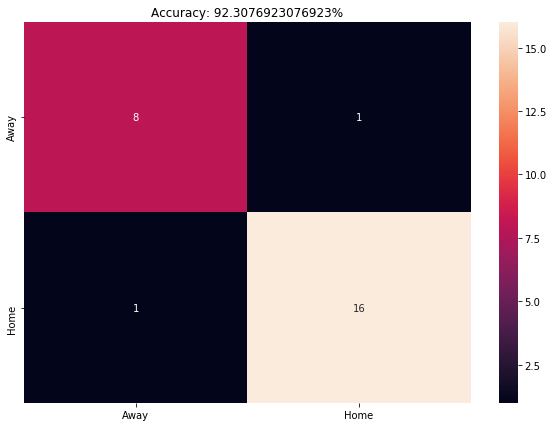

In [215]:
test_tree(testing_data)

In [200]:
train_tree(training_data)

HST
